In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy.io import fits
from astropy.table import Table

from astropy import units as u
from astropy import constants as const

from astropy.coordinates import SkyCoord, match_coordinates_sky

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
# chatGPT S/N calc
import numpy as np
from astropy.constants import h, c
from astropy import units as u


def compute_exposure_time(magnitude, diameter_m, snr_goal, resolution, 
                          central_wavelength_nm=550, wavelength_range_nm=100, 
                          throughput=0.15):
    """
    Estimate exposure time to reach a target SNR per resolution element
    for a given object magnitude, telescope aperture, and spectrograph parameters.

    Parameters:
    - magnitude (float): Object magnitude in V or R band.
    - diameter_m (float): Telescope aperture diameter in meters.
    - snr_goal (float): Desired signal-to-noise ratio per resolution element.
    - resolution (float): Spectral resolution (lambda / delta_lambda).
    - central_wavelength_nm (float): Central wavelength of observation in nm.
    - wavelength_range_nm (float): Total wavelength range in nm.
    - throughput (float): Total system throughput (0 < throughput <= 1).

    Returns:
    - exposure_time_sec (float): Estimated exposure time in seconds.
    """
    # Convert inputs to CGS units
    lambda_c = central_wavelength_nm * 1e-7 * u.cm  # cm
    bandwidth_A = wavelength_range_nm * 10 * u.AA  # in Angstroms

    # Flux of a 0-mag star at 550 nm ~ 3.6e-9 erg/cm^2/s/Å
    F0 = 3.6e-9 * u.erg / (u.cm**2 * u.s * u.AA)
    F_lambda = F0 * 10**(-0.4 * magnitude)  # erg/cm^2/s/Å

    # Photon energy at central wavelength
    E_photon = (h * c / lambda_c).to(u.erg)

    # Photon flux per Angstrom (no .to conversion here to avoid UnitConversionError)
    phi_per_A = F_lambda / E_photon  # photons/cm^2/s/Å

    # Resolution element width in Angstroms
    delta_lambda_A = (central_wavelength_nm / resolution) * 10 * u.AA

    # Photon flux per resolution element
    phi_res = phi_per_A * delta_lambda_A  # photons/cm^2/s

    # Telescope collecting area
    area_cm2 = (np.pi * (diameter_m * 100 / 2)**2) * u.cm**2

    # Photon count rate per res element
    count_rate = (phi_res * area_cm2 * throughput).to(1 / u.s)

    # Time to reach desired SNR (SNR ~ sqrt(N) => N = SNR^2)
    photons_needed = snr_goal**2
    exposure_time_sec = photons_needed / count_rate.value

    return exposure_time_sec


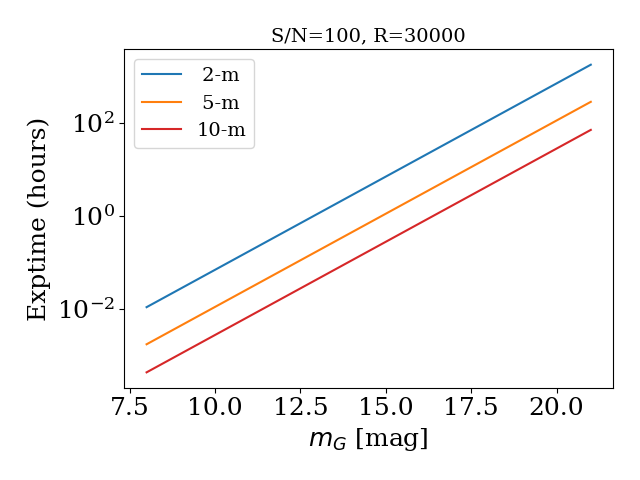

In [26]:
mag_test = np.arange(8,22,1)

t1_test = compute_exposure_time(magnitude=mag_test,
        diameter_m=2,
        snr_goal=100,
        resolution=30000,
        central_wavelength_nm=650,
        wavelength_range_nm=400,
        throughput=0.05)
t2_test = compute_exposure_time(magnitude=mag_test,
        diameter_m=5,
        snr_goal=100,
        resolution=30000,
        central_wavelength_nm=650,
        wavelength_range_nm=400,
        throughput=0.05)
t3_test = compute_exposure_time(magnitude=mag_test,
        diameter_m=10,
        snr_goal=100,
        resolution=30000,
        central_wavelength_nm=650,
        wavelength_range_nm=400,
        throughput=0.05)

plt.figure()
plt.plot(mag_test, t1_test/60/60, c='C0',label=' 2-m')
plt.plot(mag_test, t2_test/60/60, c='C1', label=' 5-m')
plt.plot(mag_test, t3_test/60/60, c='C3', label='10-m')
plt.yscale('log')
plt.xlabel('$m_G$ [mag]')
plt.ylabel('Exptime (hours)')
plt.title('S/N=100, R=30000',fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('exptime_1.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

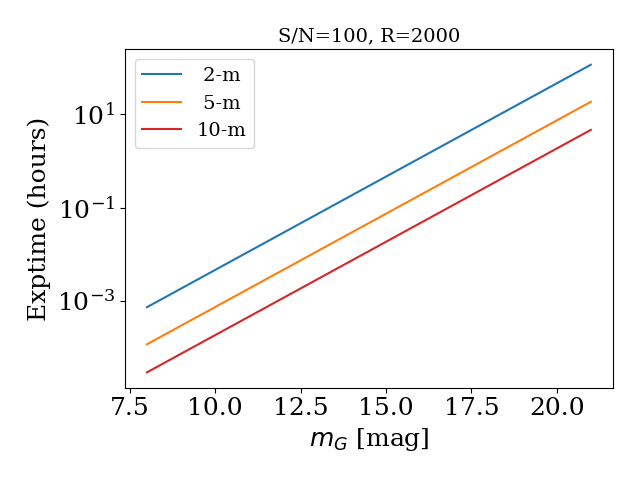

In [27]:
mag_test = np.arange(8,22,1)

t1_test = compute_exposure_time(magnitude=mag_test,
        diameter_m=2,
        snr_goal=100,
        resolution=2000,
        central_wavelength_nm=650,
        wavelength_range_nm=400,
        throughput=0.05)
t2_test = compute_exposure_time(magnitude=mag_test,
        diameter_m=5,
        snr_goal=100,
        resolution=2000,
        central_wavelength_nm=650,
        wavelength_range_nm=400,
        throughput=0.05)
t3_test = compute_exposure_time(magnitude=mag_test,
        diameter_m=10,
        snr_goal=100,
        resolution=2000,
        central_wavelength_nm=650,
        wavelength_range_nm=400,
        throughput=0.05)

plt.figure()
plt.plot(mag_test, t1_test/60/60, c='C0',label=' 2-m')
plt.plot(mag_test, t2_test/60/60, c='C1', label=' 5-m')
plt.plot(mag_test, t3_test/60/60, c='C3', label='10-m')
plt.yscale('log')
plt.xlabel('$m_G$ [mag]')
plt.ylabel('Exptime (hours)')
plt.title('S/N=100, R=2000',fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('exptime_2.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [6]:
t_sec = compute_exposure_time(
        magnitude=13,
        diameter_m=3.5,
        snr_goal=100,
        resolution=30000,
        central_wavelength_nm=650,
        wavelength_range_nm=400,
        throughput=0.05)

t_sec/60 # minutes

21.51401902013317

In [7]:
t_sec = compute_exposure_time(
        magnitude=17,
        diameter_m=3.5,
        snr_goal=100,
        resolution=2000,
        central_wavelength_nm=650,
        wavelength_range_nm=400,
        throughput=0.05)

t_sec/60 # minutes

57.099234928929015

In [8]:
t_sec = compute_exposure_time(
        magnitude=20,
        diameter_m=10,
        snr_goal=100,
        resolution=30000,
        central_wavelength_nm=650,
        wavelength_range_nm=400,
        throughput=0.05)

t_sec/60 # minutes

1662.86746797985

In [9]:
# https://arxiv.org/abs/2012.02061
GCNS_file = '../lonely_stars/GCNS_cat.fits'
GCNS = Table.read(GCNS_file, format='fits')

GCNS_c = SkyCoord(GCNS['RA'].value*u.degree, GCNS['DEC'].value*u.degree)

# past me already did this, yay! 
# https://github.com/jradavenport/lonely_stars/blob/main/GCNS_KDTree.ipynb
# c1 = SkyCoord(ra = GCNS['RA'] * u.degree,
#               dec = GCNS['DEC'] * u.degree,
#               distance= GCNS['DIST_50'] * u.kpc,
#               frame='icrs')


In [10]:
GCNS.columns['PHOT_G_MEAN_MAG'].value.data


array([15.777896,  8.942914, 10.852061, ..., 14.810236, 17.474339,
       19.264618], dtype='>f8')

In [11]:
t_gcns = compute_exposure_time(
        magnitude=GCNS['PHOT_G_MEAN_MAG'].value.data,
        diameter_m=10,
        snr_goal=100,
        resolution=30000,
        central_wavelength_nm=650,
        wavelength_range_nm=400,
        throughput=0.05)

In [12]:
t_gcns

array([2.04252456e+03, 3.76855178e+00, 2.18692197e+01, ...,
       8.37728494e+02, 9.74416181e+03, 5.06822734e+04])

In [13]:
np.nansum(t_gcns/60.)

77741523.63225041

Text(0, 0.5, 'ExpTime (min)')

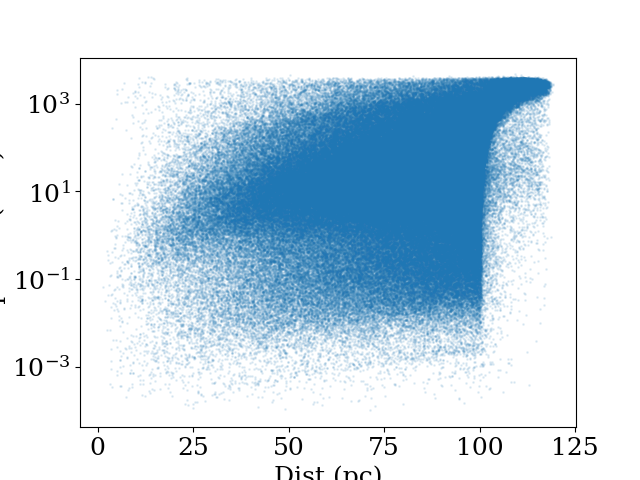

In [14]:
plt.figure()
plt.scatter(GCNS['DIST_50']*1000, t_gcns/60., s=1, alpha=0.1)
plt.yscale('log')
plt.xlabel('Dist (pc)')
plt.ylabel('ExpTime (min)')


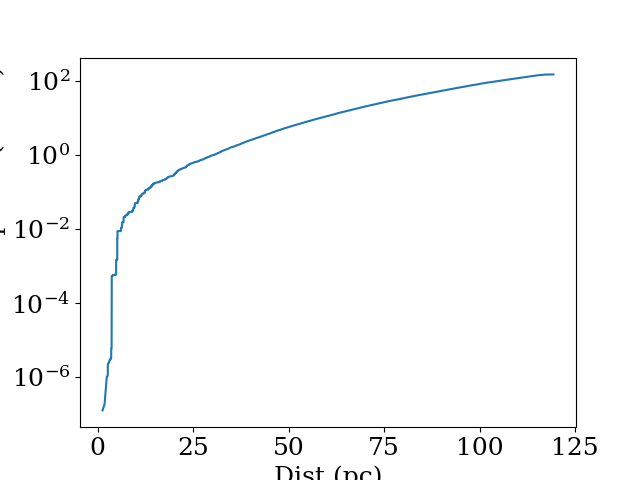

In [15]:
plt.figure()
plt.plot(GCNS['DIST_50'][np.argsort(GCNS['DIST_50'].value)]*1000, 
         np.nancumsum(t_gcns[np.argsort(GCNS['DIST_50'].value)])/60/60/24/365
        )
plt.yscale('log')
plt.xlabel('Dist (pc)')
plt.ylabel('Cumulative Exptime (Years)')
plt.savefig('cumul_exptime_v0.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [16]:
t_2 = compute_exposure_time(
        magnitude=GCNS['PHOT_G_MEAN_MAG'].value.data,
        diameter_m=2,
        snr_goal=100,
        resolution=30000,
        central_wavelength_nm=650,
        wavelength_range_nm=400,
        throughput=0.05)

t_5 = compute_exposure_time(
        magnitude=GCNS['PHOT_G_MEAN_MAG'].value.data,
        diameter_m=5,
        snr_goal=100,
        resolution=30000,
        central_wavelength_nm=650,
        wavelength_range_nm=400,
        throughput=0.05)

t_10 = compute_exposure_time(
        magnitude=GCNS['PHOT_G_MEAN_MAG'].value.data,
        diameter_m=10,
        snr_goal=100,
        resolution=30000,
        central_wavelength_nm=650,
        wavelength_range_nm=400,
        throughput=0.05)


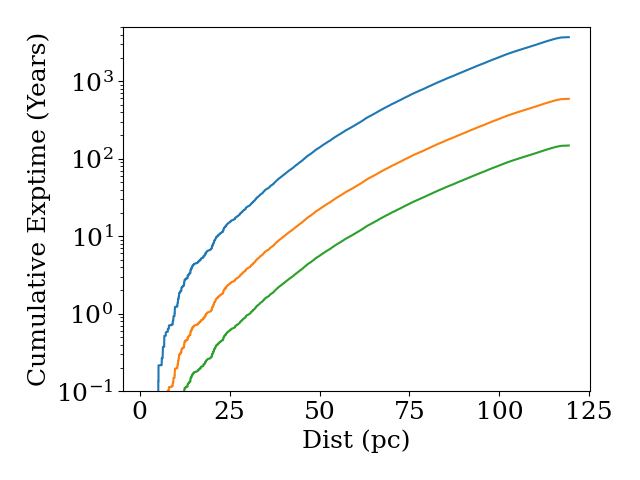

In [17]:
plt.figure()
plt.plot(GCNS['DIST_50'][np.argsort(GCNS['DIST_50'].value)]*1000, 
         np.nancumsum(t_2[np.argsort(GCNS['DIST_50'].value)])/60/60/24/365
        )
plt.plot(GCNS['DIST_50'][np.argsort(GCNS['DIST_50'].value)]*1000, 
         np.nancumsum(t_5[np.argsort(GCNS['DIST_50'].value)])/60/60/24/365
        )
plt.plot(GCNS['DIST_50'][np.argsort(GCNS['DIST_50'].value)]*1000, 
         np.nancumsum(t_10[np.argsort(GCNS['DIST_50'].value)])/60/60/24/365
        )

plt.yscale('log')
plt.ylim(0.1,5e3)
plt.xlabel('Dist (pc)')
plt.ylabel('Cumulative Exptime (Years)')
plt.tight_layout()
# plt.savefig('cumul_exptime_v0.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

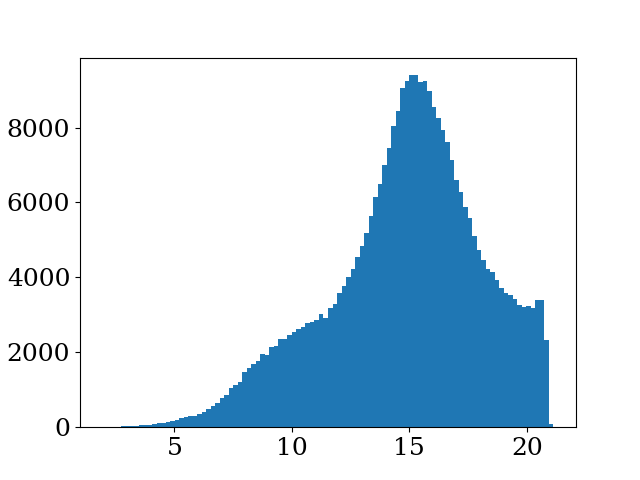

In [18]:
plt.figure()
_=plt.hist(GCNS['PHOT_G_MEAN_MAG'], bins=100)

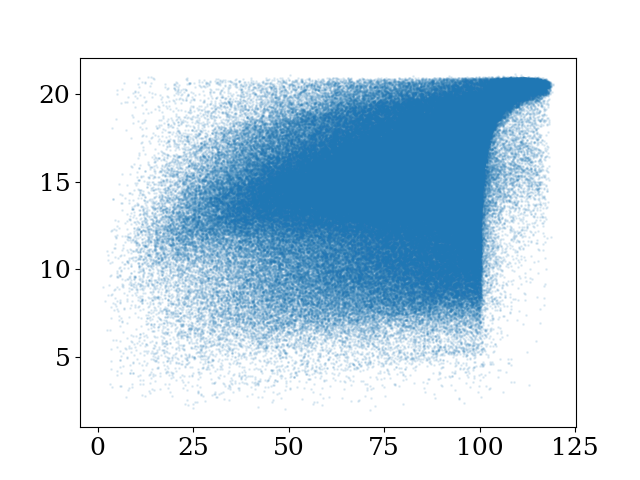

In [19]:
plt.figure()
plt.scatter(GCNS['DIST_50']*1000, GCNS['PHOT_G_MEAN_MAG'], s=1, alpha=0.1)
# plt.xscale('log')
# plt.xlim(10,120)

In [20]:
# model 1
r1 = (GCNS['PHOT_G_MEAN_MAG'] < 14)
r2 = (GCNS['PHOT_G_MEAN_MAG'] >= 14) & (GCNS['PHOT_G_MEAN_MAG'] < 17)
r3 = (GCNS['PHOT_G_MEAN_MAG'] >= 17) & (GCNS['PHOT_G_MEAN_MAG'] < 19)
r4 = (GCNS['PHOT_G_MEAN_MAG'] >= 19)

print(np.nansum(t_2[r1])/60/60/24/365, np.nansum(t_5[r2])/60/60/24/365, np.nansum(t_10[r3])/60/60/24/365, np.nansum(t_10[r4])/60/60/24/365)

9.218462771985179 34.33148212921243 26.90641987077737 112.05202365881487


In [21]:
print(np.nansum(r1), np.nansum(r2), np.nansum(r3), np.nansum(r4))

114379 132257 51176 33069


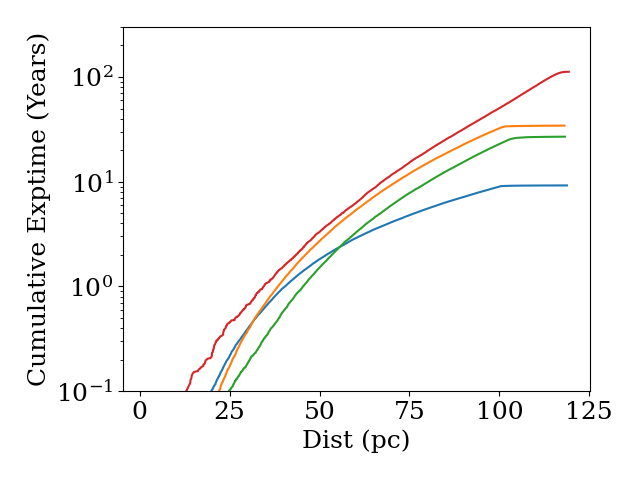

In [22]:
plt.figure()
plt.plot(GCNS['DIST_50'][r1][np.argsort(GCNS['DIST_50'].value[r1])]*1000, 
         np.nancumsum(t_2[r1][np.argsort(GCNS['DIST_50'].value[r1])])/60/60/24/365
        )

plt.plot(GCNS['DIST_50'][r2][np.argsort(GCNS['DIST_50'].value[r2])]*1000, 
         np.nancumsum(t_5[r2][np.argsort(GCNS['DIST_50'].value[r2])])/60/60/24/365
        )
plt.plot(GCNS['DIST_50'][r3][np.argsort(GCNS['DIST_50'].value[r3])]*1000, 
         np.nancumsum(t_10[r3][np.argsort(GCNS['DIST_50'].value[r3])])/60/60/24/365
        )
plt.plot(GCNS['DIST_50'][r4][np.argsort(GCNS['DIST_50'].value[r4])]*1000, 
         np.nancumsum(t_10[r4][np.argsort(GCNS['DIST_50'].value[r4])])/60/60/24/365
        )


plt.yscale('log')
plt.ylim(0.1,300)
plt.xlabel('Dist (pc)')
plt.ylabel('Cumulative Exptime (Years)')
plt.tight_layout()
# plt.grid()
# plt.savefig('cumul_exptime_v0.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

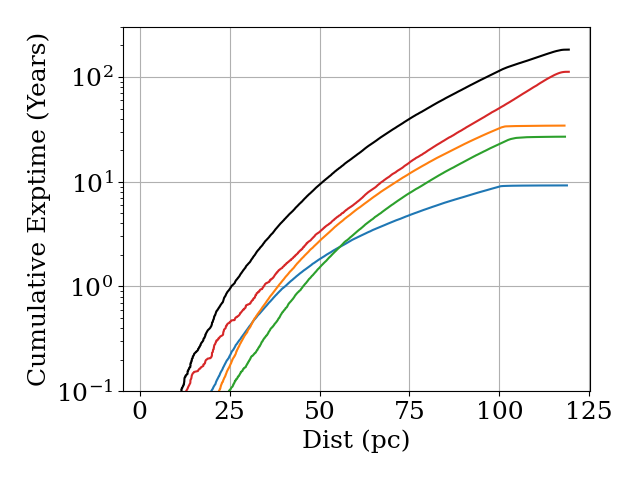

In [23]:
distances = np.concatenate((GCNS['DIST_50'][r1], GCNS['DIST_50'][r2], GCNS['DIST_50'][r3], GCNS['DIST_50'][r4]))
exptimes = np.concatenate((t_2[r1], t_5[r2], t_10[r3], t_10[r4]))

plt.figure()
plt.plot(distances[np.argsort(distances)]*1000, np.nancumsum(exptimes[np.argsort(distances)])/60/60/24/365, c='k')

plt.plot(GCNS['DIST_50'][r1][np.argsort(GCNS['DIST_50'].value[r1])]*1000, 
         np.nancumsum(t_2[r1][np.argsort(GCNS['DIST_50'].value[r1])])/60/60/24/365
        )

plt.plot(GCNS['DIST_50'][r2][np.argsort(GCNS['DIST_50'].value[r2])]*1000, 
         np.nancumsum(t_5[r2][np.argsort(GCNS['DIST_50'].value[r2])])/60/60/24/365
        )
plt.plot(GCNS['DIST_50'][r3][np.argsort(GCNS['DIST_50'].value[r3])]*1000, 
         np.nancumsum(t_10[r3][np.argsort(GCNS['DIST_50'].value[r3])])/60/60/24/365
        )
plt.plot(GCNS['DIST_50'][r4][np.argsort(GCNS['DIST_50'].value[r4])]*1000, 
         np.nancumsum(t_10[r4][np.argsort(GCNS['DIST_50'].value[r4])])/60/60/24/365
        )



plt.yscale('log')
plt.ylim(0.1,300)
plt.xlabel('Dist (pc)')
plt.ylabel('Cumulative Exptime (Years)')
plt.tight_layout()
plt.grid()

In [24]:
# ideas...
# 1. check the math above, get a proper sense of how long to observe ALL of it. 50pc ~ 10 yr, 100pc ~100yr?
# 2. what if we just did FGK main sequence stars?
# 3. sky density of sources, can we justify multi-fiber?
# 4. compute sensitivity needed to get uniform laser emission depth to 100pc, etc
# 5. do laser sensitivity for low-res to 100pc, since we actually probably quite close to low-res (R~1500)

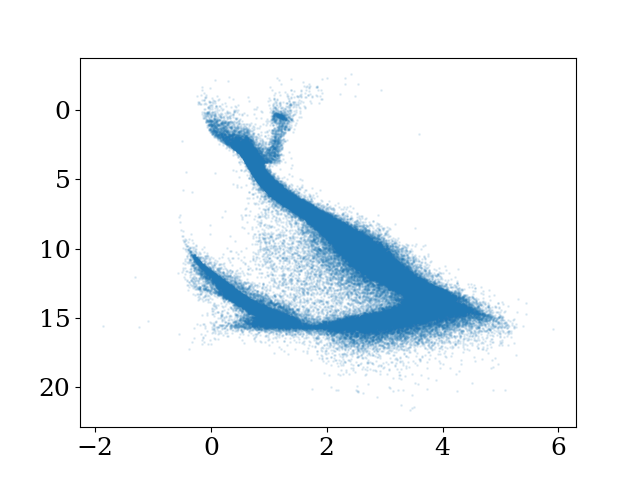

In [25]:
GCNSdf = GCNS.to_pandas()
plt.figure()
_ = plt.scatter(GCNSdf['PHOT_BP_MEAN_MAG'].values - GCNSdf['PHOT_RP_MEAN_MAG'].values, 
               GCNSdf['PHOT_G_MEAN_MAG'].values - 5*np.log10(GCNSdf['DIST_50'].values*1000) + 5, s=1,alpha=0.1)


plt.gca().invert_yaxis()